In [2]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from utils.latex import LatexHelpers

In [2]:
ERROR_METRICS = [
    "MSE",
    "average error",
    "highest error",
    "accuracy",
    "precision (multiclass)",
    "precision (micro)",
    "precision (macro)",
    "recall (multiclass)",
    "recall (micro)",
    "recall (macro)",
    "$F_1$ (multiclass)",
    "$F_1$ (micro)",
    "$F_1$ (macro)",
    "confusion matrix",
]


def add_errors_to_table(
    df_metrics: pd.DataFrame, y_true: pd.Series, y_pred: pd.Series, model_name: str
) -> None:

    # MSE
    df_metrics.loc[model_name, ERROR_METRICS[0]] = metrics.mean_squared_error(
        y_true, y_pred
    )
    df_metrics.loc[model_name, ERROR_METRICS[1]] = np.average(y_true - y_pred)
    # highest error
    er = y_true - y_pred
    mx = np.max(er)
    mn = np.min(er)
    df_metrics.loc[model_name, ERROR_METRICS[2]] = int(mn if abs(mn) > mx else mx)
    # accuracy
    df_metrics.loc[model_name, ERROR_METRICS[3]] = metrics.accuracy_score(
        y_true, y_pred
    )
    # precision
    df_metrics.loc[model_name, ERROR_METRICS[4]] = [
        round(float(x), 2)
        for x in metrics.precision_score(y_true, y_pred, average=None, zero_division=0)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[5]] = metrics.precision_score(
        y_true, y_pred, average="micro", zero_division=0
    )
    df_metrics.loc[model_name, ERROR_METRICS[6]] = metrics.precision_score(
        y_true, y_pred, average="macro", zero_division=0
    )
    # recall
    df_metrics.loc[model_name, ERROR_METRICS[7]] = [
        round(float(x), 2) for x in metrics.recall_score(y_true, y_pred, average=None)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[8]] = metrics.recall_score(
        y_true, y_pred, average="micro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[9]] = metrics.recall_score(
        y_true, y_pred, average="macro"
    )
    # F-1
    df_metrics.loc[model_name, ERROR_METRICS[10]] = [
        round(float(x), 2) for x in metrics.f1_score(y_true, y_pred, average=None)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[11]] = metrics.f1_score(
        y_true, y_pred, average="micro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[12]] = metrics.f1_score(
        y_true, y_pred, average="macro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[-1]] = metrics.confusion_matrix(
        y_true, y_pred
    )

/Users/witold/Repos/witgaw/avalanche-danger-level-forecast/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


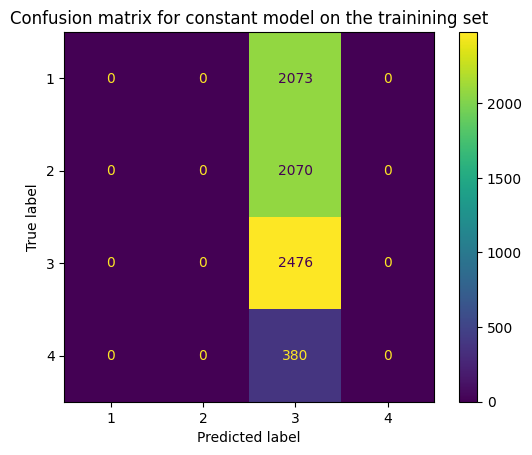

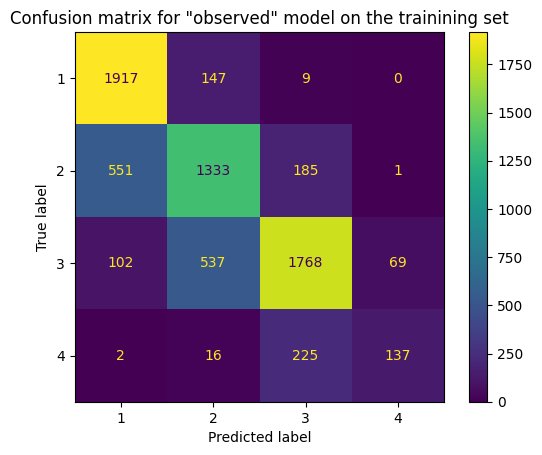

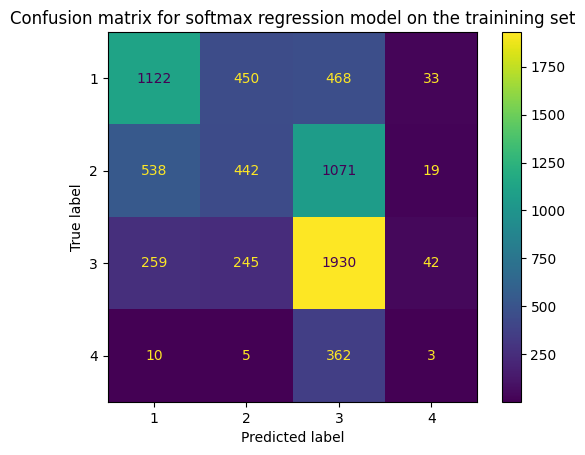

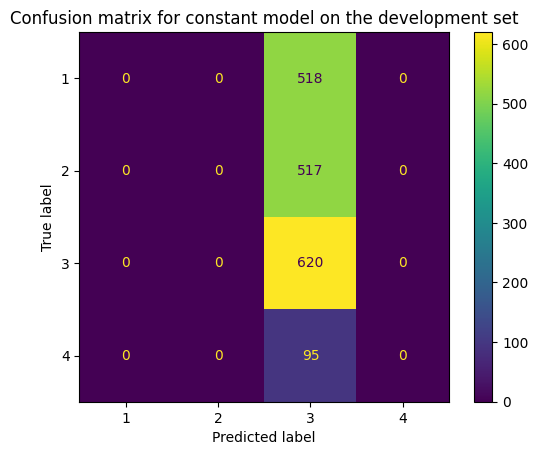

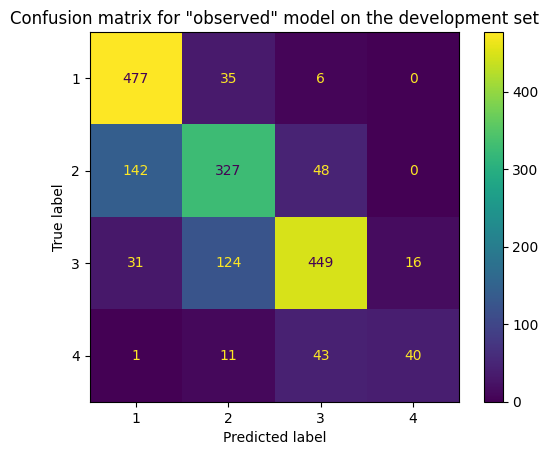

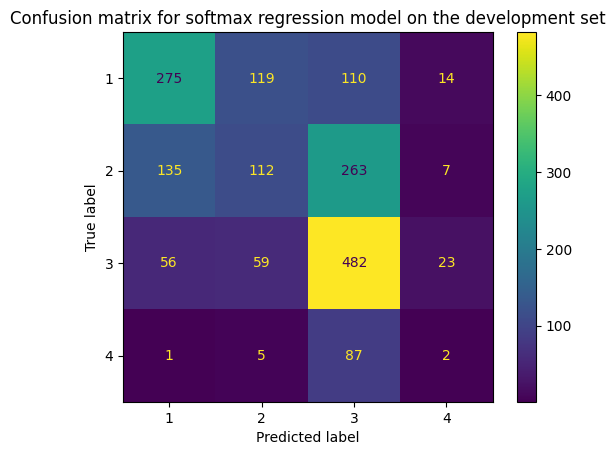

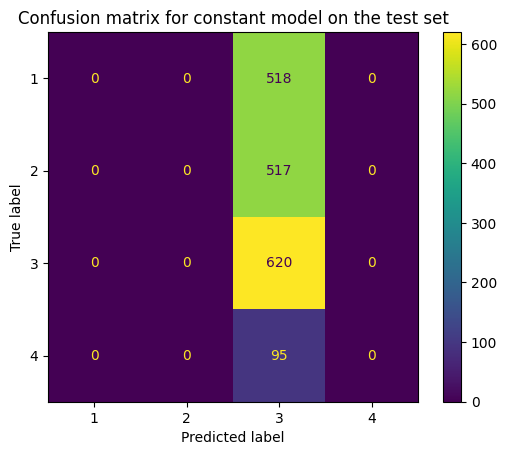

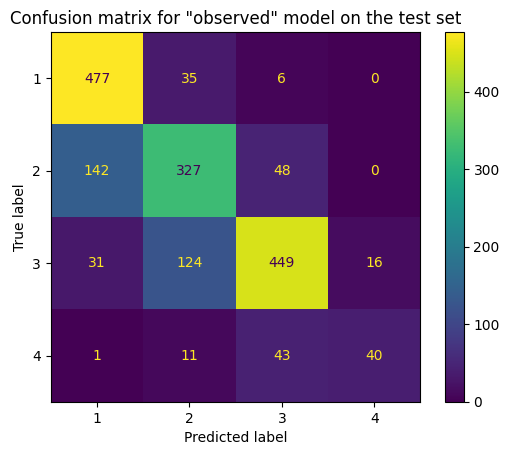

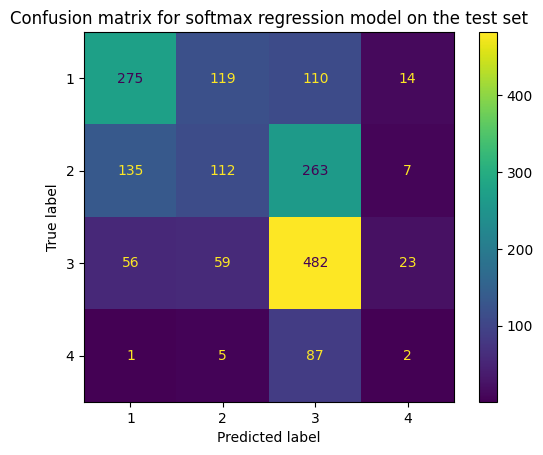

In [ ]:
df_train = pd.read_csv("../data/processed/SAIS_train.csv").drop('Date', axis=1)
df_dev = pd.read_csv("../data/processed/SAIS_dev.csv").drop('Date', axis=1)
df_test = pd.read_csv("../data/processed/SAIS_test.csv").drop('Date', axis=1)

classes = sorted(df_train["mapped_hazard_forecast"].unique())

baseline_observed = lambda x: x["mapped_hazard_observed"]
baseline_constant = lambda x: pd.Series(np.zeros(len(x)) + most_frequent_value)

# fit softmax regression model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

X_train = df_train.drop(
    columns=["mapped_hazard_forecast", "mapped_hazard_observed", "Area"]
)
y_train = df_train["mapped_hazard_forecast"]


steps = [('scaler', StandardScaler()),
     ('model',LogisticRegression(random_state=1))] 
pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)
pipeline.predict(X_train)

df_metrics_train = pd.DataFrame(columns=ERROR_METRICS)
df_metrics_dev = pd.DataFrame(columns=ERROR_METRICS)
df_metrics_test = pd.DataFrame(columns=ERROR_METRICS)

all_sets = [df_train, df_dev, df_dev]
all_set_descriptions = ["trainining", "development", "test"]
all_metrics = [df_metrics_train, df_metrics_dev, df_metrics_test]

most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]


for i, ds in enumerate(all_sets):
    y_true = ds["mapped_hazard_forecast"]
    add_errors_to_table(all_metrics[i], y_true, baseline_constant(ds), "constant")
    add_errors_to_table(all_metrics[i], y_true, baseline_observed(ds), '"observed"')
    add_errors_to_table(
        all_metrics[i],
        y_true,
        clf.predict(
            ds.drop(
                columns=["mapped_hazard_forecast", "mapped_hazard_observed", "Area"]
            )
        ),
        "softmax regression",
    )

df_metrics_dev
df_metrics_test

for i in range(len(all_metrics)):
    confusion_matrices = all_metrics[i].iloc[:, -1]
    table = all_metrics[i].iloc[:, :-1].T
    LatexHelpers.save_as_latex_table(
        table,
        name=f"sais_eval_{all_set_descriptions[i]}",
        caption=f"Evaluation metrics computed on the {all_set_descriptions[i]} set",
        path="../tex/assets/tables",
    )
    for j in range(len(confusion_matrices.index)):
        model_name = confusion_matrices.index[j]
        confusion_matrix = confusion_matrices.iloc[j]
        disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix, display_labels=classes
        )

        disp.plot()
        plt.title(
            f"Confusion matrix for {model_name} model on the {all_set_descriptions[i]} set"
        )
        plt.savefig(
            f"../tex/assets/figures/sais_confusion_matrix_{model_name.replace('"','').replace(' ','_')}_{all_set_descriptions[i]}.png"
        )

In [ ]:
seasons = pd.read_csv("../data/aux/SAIS_seasons.csv")
max_season_length = seasons['day_diff'].max()

# TODO:
#  - generic method which creates a vector of seasons-worth of observations
#      - extract to a separate file and test
#      - run for datasets
#  - rerun previous models

df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)[0:3]

df_dev = pd.read_csv("../data/processed/SAIS_dev.csv", index_col=0)[0:3]

df_combined = pd.concat([df_train, df_dev], ignore_index=False)


def tabularise_data_by_season_and_area(seasons: pd.DataFrame, data: pd.DataFrame, dependent_variables: np.array, season_max_lookback: int, include_seasons_day: bool, skip_missing_days: bool) -> pd.DataFrame:
    data['Date'] = pd.to_datetime(data['Date'])
    
    col_seasons_day = "day_of_season"
    other_variables = list(set( data.columns.tolist()) - set(dependent_variables)) 
    dependent_columns = [f"{var.lower().replace(" ", "")}_{i}" for var in dependent_variables for i in range(season_max_lookback)]

    all_columns = other_variables.copy()
    if include_seasons_day:
        all_columns.append(col_seasons_day)
    all_columns+=dependent_columns
    index = "index"

    cols = [index]
    cols.extend(all_columns)
    output = pd.DataFrame(columns= cols)
   
    indices = [i*season_max_lookback for i in range(len(dependent_variables))]

    for _, season in seasons.iterrows():
        start = pd.to_datetime(season['season_start'])
        end = pd.to_datetime(season['season_end'])
        season_data = data[(data['Date'] >= start) & (data['Date'] <= end)]

        for _, area_data in season_data.groupby('Area',as_index=False):
            area_data = area_data.sort_values(by='Date', ascending=True)
            dependent_row_bit = np.zeros(len(dependent_columns))
            day_of_season_prev = 0
            
            for idx, row_input in area_data.iterrows():
                day_of_season = (row_input['Date'] - start).days + 1
                shift = 1 if skip_missing_days else day_of_season - day_of_season_prev

                dependent_row_bit = np.roll(dependent_row_bit,shift)
                dependent_row_bit[0:shift] = 0

                row_output = [idx]
                row_output.extend(row_input[other_variables])
                if include_seasons_day:
                    row_output.append(day_of_season)

                dependent_row_bit[indices] = row_input[dependent_variables]
                row_output.extend(dependent_row_bit)
                
                output.loc[len(output)] = row_output 

                day_of_season_prev = day_of_season
    
    return output.set_index(index)

dependent_variables = list(set(df_train.columns.tolist()) - set(["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]))

df_combined_tab = tabularise_data_by_season_and_area(seasons=seasons, data=df_combined, dependent_variables=dependent_variables, season_max_lookback=max_season_length, include_seasons_day=True, skip_missing_days=True)

df_train_tab = df_combined_tab.loc[df_train.index]
df_dev_tab = df_combined_tab.loc[df_dev.index]

# df_train.to_csv("../data/processed/SAIS_train_tabularised.csv", index=False)
# df_dev.to_csv("../data/processed/SAIS_dev_tabularised.csv", index=False)

   